In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle_API/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
import kaggle

In [4]:
!kaggle datasets download -d landlord/handwriting-recognition

Dataset URL: https://www.kaggle.com/datasets/landlord/handwriting-recognition
License(s): CC0-1.0
 99% 1.25G/1.26G [00:07<00:00, 139MB/s]
100% 1.26G/1.26G [00:07<00:00, 182MB/s]


In [5]:
%%capture
!unzip handwriting-recognition.zip -d dataset;

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
import pandas as pd

In [14]:
train_df = pd.read_csv(r'/content/dataset/written_name_train_v2.csv')
valid_df = pd.read_csv(r'/content/dataset/written_name_validation_v2.csv')
print(train_df.head())

          FILENAME   IDENTITY
0  TRAIN_00001.jpg  BALTHAZAR
1  TRAIN_00002.jpg      SIMON
2  TRAIN_00003.jpg      BENES
3  TRAIN_00004.jpg    LA LOVE
4  TRAIN_00005.jpg     DAPHNE


In [15]:
print(train_df.isna().sum())
print(valid_df.isna().sum())

FILENAME      0
IDENTITY    565
dtype: int64
FILENAME     0
IDENTITY    78
dtype: int64


In [16]:
train_df.dropna(inplace=True)
valid_df.dropna(inplace=True)

In [17]:
print(train_df.isna().sum())
print(valid_df.isna().sum())

FILENAME    0
IDENTITY    0
dtype: int64
FILENAME    0
IDENTITY    0
dtype: int64


In [18]:
# train_df['IDENTITY'] = train_df['IDENTITY'].str.lower()
# valid_df['IDENTITY'] = valid_df['IDENTITY'].str.lower()
# train_df['IDENTITY'].apply(lambda x: x.split(" ")[-1].strip())
# valid_df['IDENTITY'].apply(lambda x: x.split(" ")[-1].strip())

In [19]:
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_df['IDENTITY']:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

Maximum length:  21
Vocab size:  49


In [20]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels

train_labels = clean_labels(train_df['IDENTITY'])
valid_labels = clean_labels(valid_df['IDENTITY'])

In [21]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=list(characters), mask_token=None)
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

In [22]:
def img_preprocess(img, img_size):
  w, h = img_size
  img = tf.image.resize(img, [w, h], preserve_aspect_ratio = True)

  pad_h = h - tf.keras.ops.shape(img)[0]
  pad_w = w - tf.keras.ops.shape(img)[1]

  if pad_h % 2 != 0:
        height = pad_h // 2
        pad_height_top = height + 1
        pad_height_bottom = height
  else:
      pad_height_top = pad_height_bottom = pad_h // 2
  if pad_w % 2 != 0:
        width = pad_w // 2
        pad_width_left = width + 1
        pad_width_right = width
  else:
    pad_width_left = pad_width_right = pad_w // 2

  img = tf.pad(
      img,
      ([pad_height_top, pad_height_bottom], [pad_width_left, pad_width_right], [0, 0])
      )

  img = tf.keras.ops.transpose(img, (1, 0, 2))
  img = tf.image.flip_left_right(img)
  return img

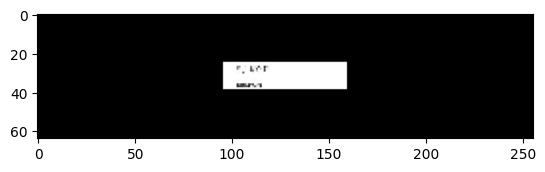

In [24]:
img = tf.io.read_file(r'/content/dataset/train_v2/train/TRAIN_00002.jpg')
img = tf.io.decode_jpeg(img, channels=1)
img = img_preprocess(img, (256, 64))
img = tf.keras.ops.transpose(img, (1, 0, 2))
plt.imshow(img, cmap = 'grey')

In [25]:
img_path_train = r'/content/dataset/train_v2/train'
img_path_val = r'/content/dataset/validation_v2/validation'

In [26]:
def prepare_dataset_train(img_path, label):
  img_path = tf.strings.join([img_path_train, img_path], separator = os.path.sep)
  img = tf.io.read_file(img_path)
  img = tf.io.decode_jpeg(img, channels=1)
  img = img_preprocess(img, (256, 64))
  img = tf.cast(img, tf.float32) / 255.0

  label = char_to_num(tf.strings.unicode_split(label, input_encoding='UTF-8'))
  label_len = tf.shape(label)[0]
  pad_amount = max_len - label_len
  label = tf.pad(label, paddings = [[0, pad_amount]], constant_values = 99)

  return {'image': img, "label": label}

def prepare_dataset_val(img_path, label):
  img_path = tf.strings.join([img_path_val, img_path], separator = os.path.sep)
  img = tf.io.read_file(img_path)
  img = tf.io.decode_jpeg(img, channels=1)
  img = img_preprocess(img, (256, 64))
  img = tf.cast(img, tf.float32) / 255.0

  label = char_to_num(tf.strings.unicode_split(label, input_encoding='UTF-8'))
  label_len = tf.shape(label)[0]
  pad_amount = max_len - label_len
  label = tf.pad(label, paddings = [[0, pad_amount]], constant_values = 99)

  return {'image': img, "label": label}

def prepare_dataset(img_path, label):
  # img_path = tf.strings.join([img_path_train, img_path], separator = os.path.sep)
  img = tf.io.read_file(img_path)
  img = tf.io.decode_jpeg(img, channels=1)
  img = img_preprocess(img, (256, 64))
  img = tf.cast(img, tf.float32) / 255.0

  label = char_to_num(tf.strings.unicode_split(label, input_encoding='UTF-8'))
  label_len = tf.shape(label)[0]
  pad_amount = max_len - label_len
  label = tf.pad(label, paddings = [[0, pad_amount]], constant_values = 99)

  return {'image': img, "label": label}

In [27]:
out = prepare_dataset(r'/content/dataset/train_v2/train/TRAIN_00002.jpg', "simon")

In [28]:
print(tf.strings.reduce_join(num_to_char(out['label'])).numpy().decode("utf-8"))

simon[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK]


In [29]:
train_data = tf.data.Dataset.from_tensor_slices((train_df['FILENAME'], train_labels))
valid_data = tf.data.Dataset.from_tensor_slices((valid_df['FILENAME'], valid_labels))

train_data = (
    train_data.map(prepare_dataset_train, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
valid_data = (
    valid_data.map(prepare_dataset_val, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

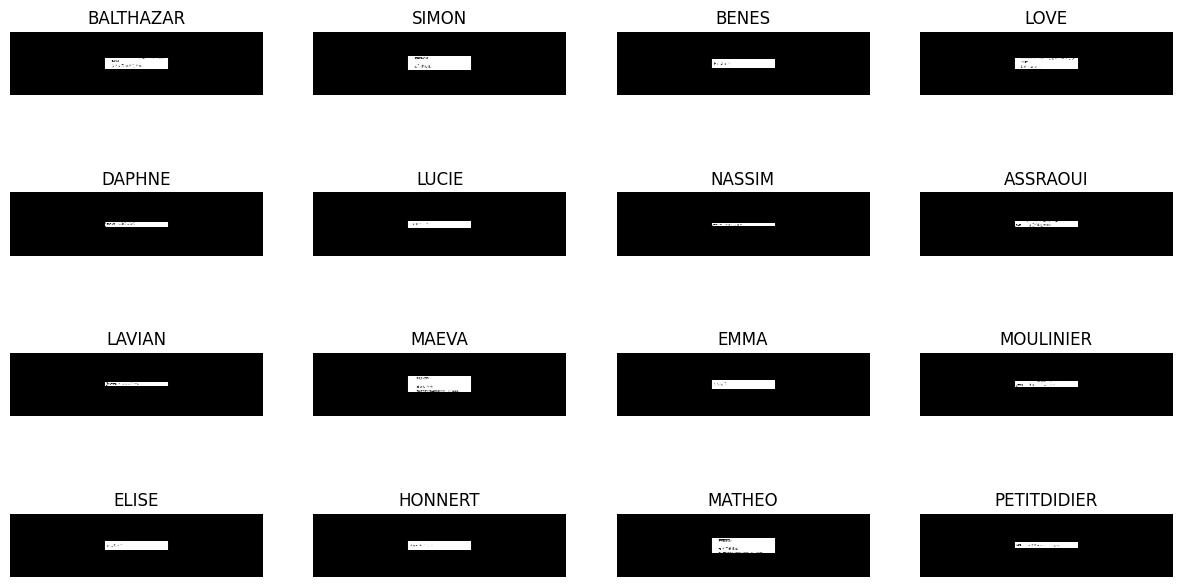

In [30]:
for data in train_data.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.keras.ops.transpose(img, (1, 0, 2))
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, 99)))
        label = tf.strings.reduce_join(num_to_char(indices)).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()


In [31]:
class ctcLayer(tf.keras.layers.Layer):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.loss_fn = tf.keras.backend.ctc_batch_cost

  def call(self, y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = self.loss_fn(y_true, y_pred, input_length, label_length)
    self.add_loss(loss)

    return y_pred

In [32]:
def nw_model(img_w, img_h):
  input_img = tf.keras.Input(shape=(img_w, img_h, 1), name="image")
  labels = tf.keras.layers.Input(name="label", shape=(None,))

  x = tf.keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
  x = tf.keras.layers.MaxPooling2D((2, 2), name="pool1")(x)
  x = tf.keras.layers.Conv2D(
      64,
      (3, 3),
      activation="relu",
      kernel_initializer="he_normal",
      padding="same",
      name="Conv2",
  )(x)
  x = tf.keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

  new_shape = ((img_w // 4), (img_h // 4) * 64)
  x = tf.keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
  x = tf.keras.layers.Dense(64, activation="relu", name="dense1")(x)
  x = tf.keras.layers.Dropout(0.2)(x)

  x = tf.keras.layers.Bidirectional(
      tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
  )(x)
  x = tf.keras.layers.Bidirectional(
      tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
  )(x)

  x = tf.keras.layers.Dense(
      len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
  )(x)

  output = ctcLayer(name="ctc_loss")(labels, x)

  model = tf.keras.models.Model(
      inputs=[input_img, labels], outputs=output, name="handwriting_recognition"
  )

  model.compile(optimizer=tf.keras.optimizers.Adam())
  return model

In [33]:
model = nw_model(256, 64)
model.summary()

Model: "handwriting_recognition"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 256, 64, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 256, 64, 32)    │            320 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 128, 32, 32)    │              0 │ Conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv2 (Conv2D)            │ (None, 128, 32, 64)    │         18,496 │ pool1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool2 (MaxPooling2D)      │ (None, 64, 16, 64)     │              0 │ Conv2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 64, 1024)       │              0 │ pool2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense1 (Dense)            │ (None, 64, 64)         │         65,600 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64, 64)         │              0 │ dense1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 64, 256)        │        197,632 │ dropout[0][0]          │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 64, 128)        │        164,352 │ bidirectional[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label (InputLayer)        │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense2 (Dense)            │ (None, 64, 52)         │          6,708 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ctc_loss (ctcLayer)       │ (None, 64, 52)         │              0 │ label[0][0],           │
│                           │                        │                │ dense2[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 453,108 (1.73 MB)

 Trainable params: 453,108 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# def calculate_edit_distance(labels, predictions):
#     saprse_labels = tf.keras.ops.cast(tf.sparse.from_dense(labels), dtype=tf.int64)
#     input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
#     predictions_decoded = tf.keraskeras.ops.nn.ctc_decode(
#         predictions, sequence_lengths=input_len
#     )[0][0][:, :max_len]
#     sparse_predictions = tf.keras.ops.cast(
#         tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
#     )
#     edit_distances = tf.edit_distance(
#         sparse_predictions, saprse_labels, normalize=False
#     )
#     return tf.reduce_mean(edit_distances)


# class EditDistanceCallback(tf.keras.callbacks.Callback):
#     def __init__(self, pred_model):
#         super().__init__()
#         self.prediction_model = pred_model

#     def on_epoch_end(self, epoch, logs=None):
#         edit_distances = []

#         for i in range(len(validation_images)):
#             labels = validation_labels[i]
#             predictions = self.prediction_model.predict(validation_images[i])
#             edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

#         print(
#             f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
#         )

In [35]:
his = model.fit(train_data, epochs = 10, validation_data = valid_data)

Epoch 1/10
10325/10325 ━━━━━━━━━━━━━━━━━━━━ 662s 63ms/step - loss: 640.5028 - val_loss: 570.6830
Epoch 2/10
10325/10325 ━━━━━━━━━━━━━━━━━━━━ 649s 61ms/step - loss: 565.6337 - val_loss: 558.5911
Epoch 3/10
10325/10325 ━━━━━━━━━━━━━━━━━━━━ 634s 61ms/step - loss: 556.9457 - val_loss: 555.2724
Epoch 4/10
  779/10325 ━━━━━━━━━━━━━━━━━━━━ 8:48 55ms/step - loss: 555.1560

KeyboardInterrupt: 

In [ ]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = tf.keras.ops.nn.ctc_decode(pred, sequence_lengths=input_len)[0][0][
        :, :max_len
    ]
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = (
            tf.strings.reduce_join(num_to_char(res))
            .numpy()
            .decode("utf-8")
            .replace("[UNK]", "")
        )
        output_text.append(res)
    return output_text

In [ ]:
prediction_model = tf.keras.models.Model(
    model.get_layer(name="image").output, model.get_layer(name="dense2").output
)